<a href="https://colab.research.google.com/github/Priyankakadam136/Text-Classification-LSTM-TensorFlow/blob/main/TensorFlowLSTMAmazonReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot

In [ ]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.5.0


In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


****
Let us define methods to pre-process the review data
****

In [ ]:



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



***

Let us pre-process the data

***

In [ ]:
review_data= pd.read_csv("Cell_Phones_and_Accessories.csv")
print(review_data.head(10))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('productID')))
print('Unique Users')
print(len(review_data.groupby('reviewerID')))

   Unnamed: 0  rating  verified   reviewTime      reviewerID   productID  \
0           0     5.0      True   08 4, 2014  A24E3SXTC62LJI  7508492919   
1           1     5.0      True  02 12, 2014  A269FLZCB4GIPV  7508492919   
2           2     3.0      True   02 8, 2014   AB6CHQWHZW4TV  7508492919   
3           3     2.0      True   02 4, 2014   A1M117A53LEI8  7508492919   
4           4     4.0      True   02 3, 2014  A272DUT8M88ZS8  7508492919   
5           5     2.0      True  01 27, 2014  A1DW2L6XCC5TJS  7508492919   
6           6     3.0      True  01 23, 2014   AQC61R4UST7UH  7508492919   
7           7     5.0      True  01 17, 2014  A31OVFL91BCKXG  7508492919   
8           8     1.0      True  12 27, 2013  A1K0VLK6O5Z22M  7508492919   
9           9     4.0      True  12 16, 2013  A1K3BWU73YB44P  7508492919   

                                          reviewText  \
0  Looks even better in person. Be careful to not...   
1  When you don't want to spend a whole lot of ca..

In [ ]:
review_data.dropna(axis = 0, how ='any',inplace=True) 





#review_data['reviewText'] = review_data['reviewText'].apply(remove_url)
review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['rating'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))


#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Dataset --------
5.0    555516
4.0    161434
3.0     90015
1.0     76692
2.0     54597
Name: rating, dtype: int64
938254
-------------------------
Train Max Sentence Length :4303


In [ ]:
review_data['Num_words_text'].describe()

count    938254.000000
mean         44.591138
std          73.916178
min           0.000000
25%          10.000000
50%          22.000000
75%          49.000000
max        4303.000000
Name: Num_words_text, dtype: float64

<AxesSubplot:xlabel='Num_words_text'>

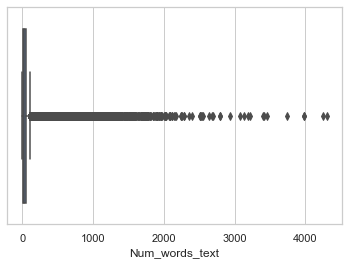

In [ ]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

***
Let us create a dataset having reviews of 100 words or less
***

In [ ]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Short reviews
411313
No of Long reviews
100239


In [ ]:
print(df_short_reviews['Num_words_text'].max())

99


In [ ]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0
    

***
Let us create our train and test datasets
***

In [ ]:
#df_short_reviews['rating'].value_counts()
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=200000, random_state =0)
train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
#train_data = df_short_reviews.sample(n=200000, random_state =0)
test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())




203891
5.0    119685
4.0     36450
3.0     19775
1.0     15606
2.0     12375
Name: rating, dtype: int64
Train data
1    175910
0     27981
Name: sentiment, dtype: int64
686345
5.0    417691
4.0    111226
3.0     63201
1.0     55746
2.0     38481
Name: rating, dtype: int64
Test data
1    592118
0     94227
Name: sentiment, dtype: int64


In [ ]:
train_data['sentiment'].value_counts()

1    175910
0     27981
Name: sentiment, dtype: int64

Let us split the training data into train and validation datasets
Let us convert our training,validation and test data into the format accepted by tensorflow

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.5,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:101945
Class distributionCounter({1: 87955, 0: 13990})
Valid data len:101946
Class distributionCounter({1: 87955, 0: 13991})


***
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
<br>
This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
***

In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[44404, 110, 24, 13]]


***
Let us create our train,validation and test tensorflow datasets
***

In [ ]:



x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)



train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(test_data['sentiment'].tolist())

print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object

Train data len:101945
Class distributionCounter({1: 87955, 0: 13990})
Validation data len:101946
Class distributionCounter({1: 87955, 0: 13991})
Test data len:686345
Class distributionCounter({1: 592118, 0: 94227})


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor(
[    4  1304   775    18  2423    41  4218  1450     2   178    41    69
   187     2   495 20463   173    47    70    17    23   391   422    57
    17   266     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
======Validation dataset ====
tf.Tensor(
[    2  1120  2842   775  1162     4   960    30    91    25  1040   451
     4   775     2  1393    34 44404    24  3623     3   437   144    34
   256    13    84     3    34    26   437     8   947  1360     2   109
    11    15   408    31  4615

****
Let us create a simple LSTM based sentiment classification  model  
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture[1] used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). For example, LSTM is applicable to tasks such as unsegmented, connected handwriting recognition,[2] speech recognition[3][4] and anomaly detection in network traffic or IDSs (intrusion detection systems).
https://en.wikipedia.org/wiki/Long_short-term_memory

For futher reading :https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

****




****
<br>
<br>
Keras is a high-level API that's easier for ML beginners, as well as researchers.
It is integrated as part of Tensorflow 
<br>
I am using the Sequential model
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Source :https://www.tensorflow.org/guide/keras/sequential_model
****

In [ ]:
max_features =50000
embedding_dim =16
sequence_length = 100

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               
model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 16)           800016    
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 16)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 16)           2112      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               819712    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                

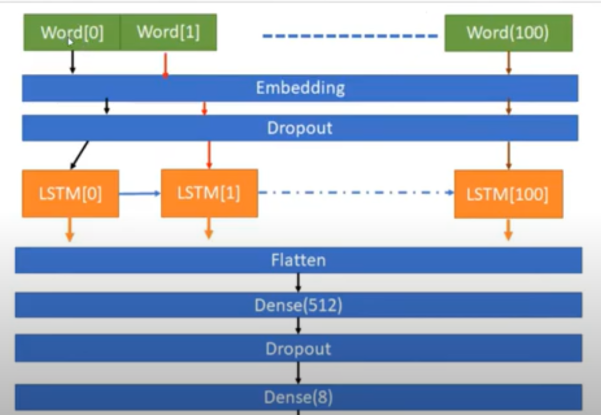

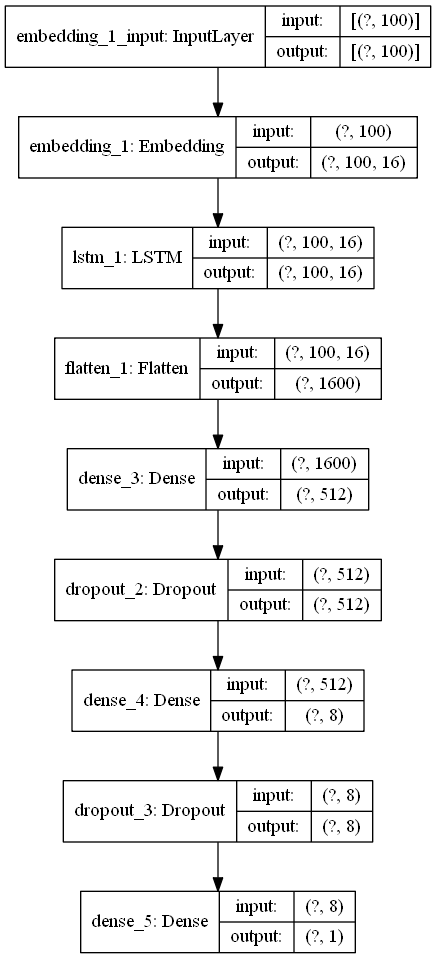

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

***
Let's train our model
***

In [ ]:
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Train for 100 steps, validate for 100 steps
Epoch 1/10
100/100 [==============================] - 14s 141ms/step - loss: 0.3865 - binary_accuracy: 0.8712 - val_loss: 0.3009 - val_binary_accuracy: 0.8987
Epoch 2/10
100/100 [==============================] - 14s 140ms/step - loss: 0.3249 - binary_accuracy: 0.8829 - val_loss: 0.2942 - val_binary_accuracy: 0.9024
Epoch 3/10
100/100 [==============================] - 14s 140ms/step - loss: 0.3232 - binary_accuracy: 0.8823 - val_loss: 0.2934 - val_binary_accuracy: 0.9026
Epoch 4/10
100/100 [==============================] - 14s 140ms/step - loss: 0.3224 - binary_accuracy: 0.8832 - val_loss: 0.2883 - val_binary_accuracy: 0.9043
Epoch 5/10
100/100 [==============================] - 14s 140ms/step - loss: 0.3149 - binary_accuracy: 0.8841 - val_loss: 0.2888 - val_binary_accuracy: 0.9057
Epoch 6/10
100/100 [==============================] - 14s 140ms/step - loss: 0.3173 - binary_accuracy: 0.8834 - val_loss: 0.2877 - val_binary_accuracy: 0.9012
Ep

In [ ]:
history.history


{'loss': [0.386958964465967,
  0.32500146996589646,
  0.3233681769390678,
  0.3224832273759173,
  0.3149244505784716,
  0.31733559709502923,
  0.3131707961349164,
  0.3124732509810119,
  0.3102747680083925,
  0.31254209608834993],
 'binary_accuracy': [0.87115604,
  0.88294667,
  0.8823483,
  0.8831625,
  0.8841434,
  0.88339794,
  0.88471234,
  0.884987,
  0.8850753,
  0.8840453],
 'val_loss': [0.30088545113801957,
  0.29418623983860015,
  0.29335328966379165,
  0.2883087232708931,
  0.2887642079591751,
  0.28766598969697954,
  0.28323347330093385,
  0.28464209735393525,
  0.28242593586444853,
  0.2842478781938553],
 'val_binary_accuracy': [0.89870125,
  0.9023993,
  0.9026445,
  0.90429246,
  0.905705,
  0.9012222,
  0.9053126,
  0.9038707,
  0.9061856,
  0.9049399]}

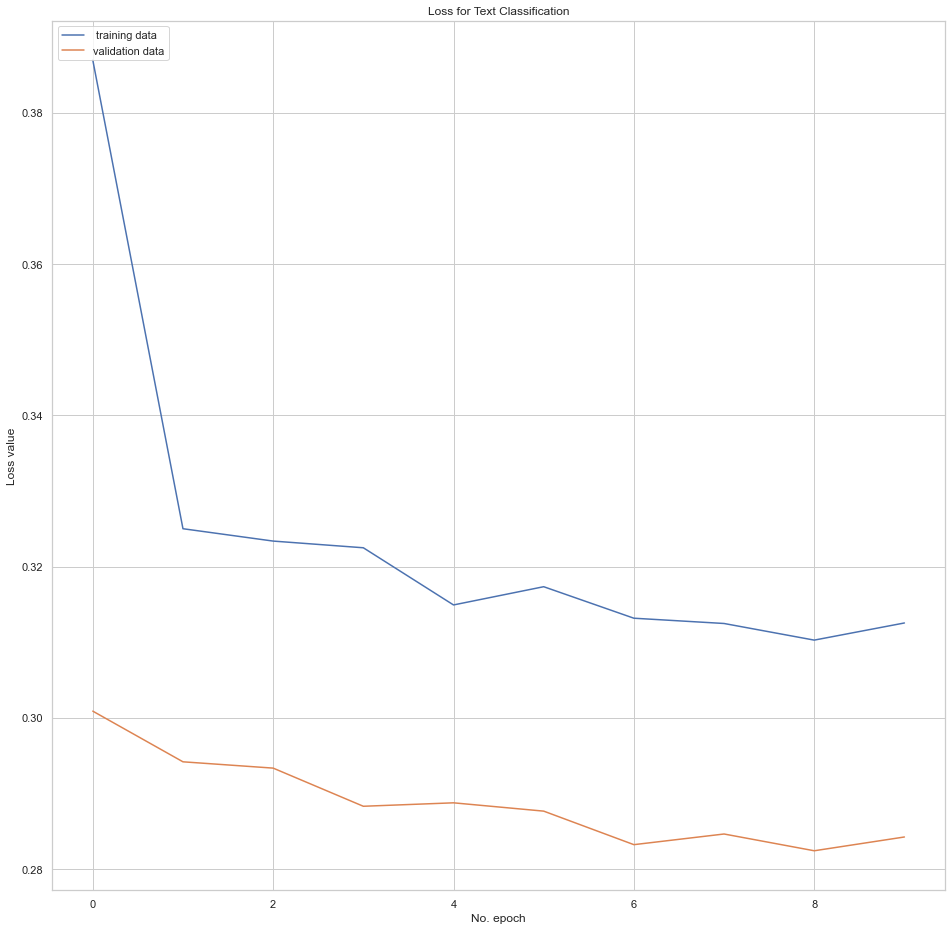

In [ ]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

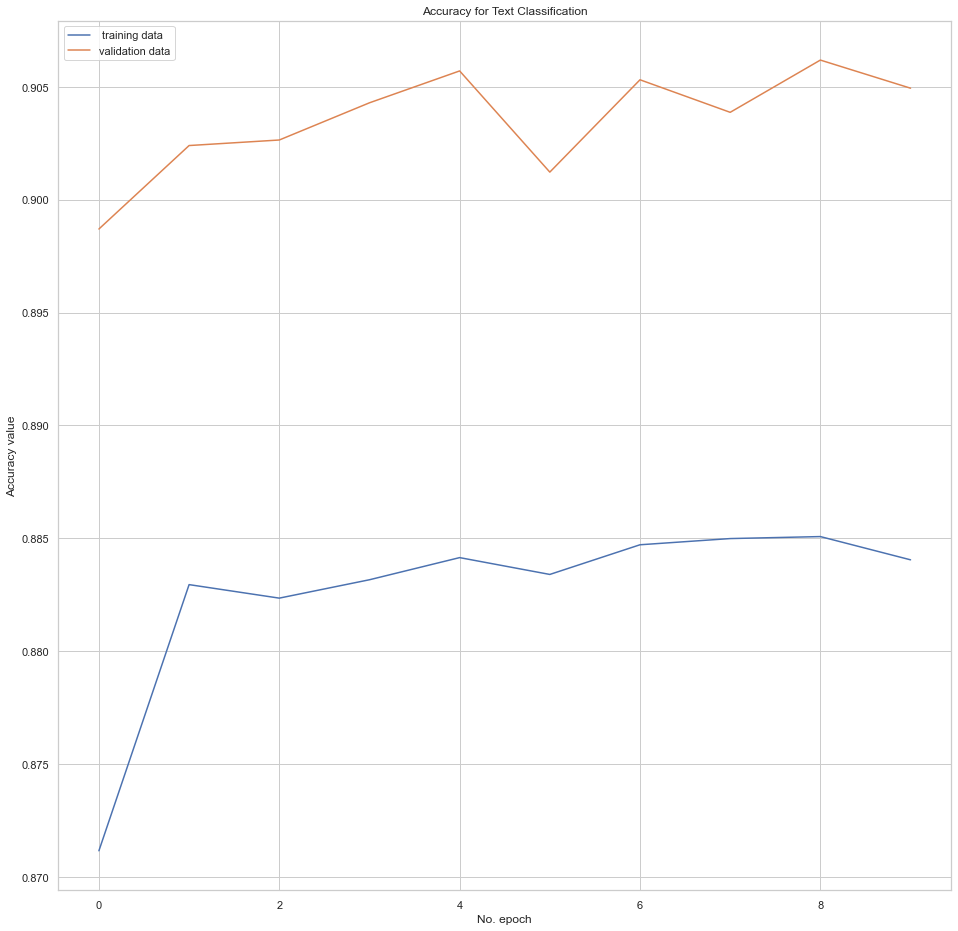

In [ ]:


plt.plot(history.history['binary_accuracy'], label=' training data')
plt.plot(history.history['val_binary_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


Lets save our model and tokenizer

In [ ]:
model.save('C:\\AmazonReviewsCellPhones\\savedTFLSTMModel\\tf_lstmmodel.h5') 
json_string = tokenizer.to_json()


In [ ]:
import json
with open('C:\\AmazonReviewsCellPhones\\savedTFLSTMModel\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)
    

In [ ]:
valid_predict= model.predict(x_valid)

In [ ]:
print(valid_predict[:10])

[[0.55312085]
 [0.9029206 ]
 [0.97503793]
 [0.71413463]
 [0.90116113]
 [0.9982704 ]
 [0.9958947 ]
 [0.99488884]
 [0.9806153 ]
 [0.93680006]]


***

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The method was developed for operators of military radar receivers, which is why it is so named

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

***

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

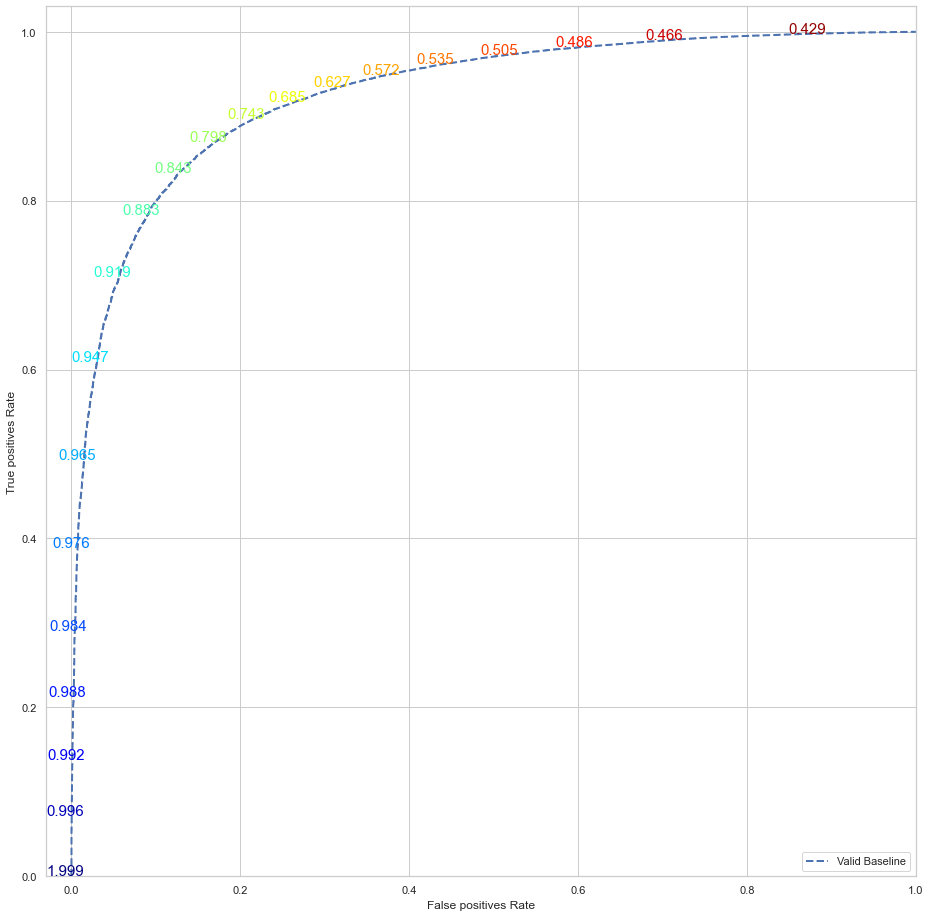

In [ ]:
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Lets load our model and test on test data

In [ ]:
new_model = tf.keras.models.load_model('C:\\AmazonReviewsCellPhones\\savedTFLSTMModel\\tf_lstmmodel.h5')
new_model.summary()


d:\tensorflow\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 16)           800016    
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 16)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 16)           2112      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               819712    
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                

In [ ]:
with open('C:\\TweetSenitment\\savedTFCNNModel\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [ ]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:

# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)



Generate predictions for all samples


In [ ]:
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.78),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.78),0,test_data.pred_sentiment)


d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
labels = [0, 1]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.57      0.81      0.67     94227
           1       0.97      0.90      0.93    592118

    accuracy                           0.89    686345
   macro avg       0.77      0.86      0.80    686345
weighted avg       0.91      0.89      0.90    686345



Conclusion - 

It concludes the overall classification over here...
Overall accuracy - 0.89
F1- score - 0.67

Text Classification using LSTM on Amazon Review Dataset with TensorFlow  - Natural Language Processing ML concepts

Data Preprocessing

Train, Test and Validation Dataset Creation

Converting Train, Test and Validation text into sequences

TensorFlow dataset creation

Creation of LSTM network

Model visualization

Model Training

Model Testing on test data

So in this particular period I explained you how we can create a Text classification model using simle LSTM with TensorFlow
